In [21]:
import numpy as np
import librosa
import os
import numpy as np
import librosa
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


In [2]:
import numpy as np
import librosa
import os
from tqdm import tqdm
import pandas as pd

def extract_mfcc(
    audio_file_path,
    sample_rate=None,
    pre_emphasis=0.97,
    frame_size=0.025,
    frame_stride=0.01,
    NFFT=512,
    nfilt=40, 
    num_ceps=12,
    fixed_length=100
):
    y, sr = librosa.load(audio_file_path, sr=sample_rate)
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    frames *= np.hamming(frame_length)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    from scipy.fftpack import dct
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

    # Обрезка или дополнение до фиксированной длины
    if mfcc.shape[0] < fixed_length:
        pad_width = fixed_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:fixed_length]

    return mfcc

In [3]:
def extract_mfcc_for_folders(data_folder, subfolders, **kwargs):
    features = []
    labels = []

    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_folder, subfolder)
        files = os.listdir(folder_path)
        for filename in tqdm(files, desc=f"Processing {subfolder}", unit="file"):
            if filename.endswith('.wav'):
                file_path = os.path.join(folder_path, filename)
                mfccs = extract_mfcc(file_path, **kwargs)
                features.append(mfccs.flatten().tolist())
                labels.append(label)

    return features, labels


In [4]:
data_folder = "../Data/data_5_class"
# data_folder = 'clean_audio'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

features, labels = extract_mfcc_for_folders(data_folder, subfolders, fixed_length=100)

df = pd.DataFrame(features)
df['label'] = labels
df.to_csv('mfcc_features.csv', index=False)

Processing tired: 100%|██████████| 998/998 [00:27<00:00, 36.54file/s]


In [5]:
data = pd.read_csv("mfcc_features.csv")
data

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,label
0,-8.171397,13.562996,2.804730,-11.426469,-5.594399,-2.529424,4.080891,3.287440,3.550831,0.213463,...,1.232623,-48.158284,-6.754266,11.575991,-17.468216,-22.046714,-7.296604,8.586168,12.721042,0
1,-24.601741,-178.280522,58.753776,-2.310084,-34.115612,5.131988,-35.499948,-12.992416,-2.256310,2.331919,...,1.961410,-28.381242,47.858484,-41.938985,-15.569322,14.708936,12.876347,4.581074,-23.606917,0
2,-3.847899,10.099561,5.577282,-14.505429,-3.971624,-3.766005,5.761777,2.036072,5.209884,-1.265300,...,4.533179,-24.488466,-4.046496,-1.043638,-2.189063,4.489057,-4.642417,15.994558,21.421836,0
3,-2.949203,9.850210,5.564964,-13.672363,-4.422107,-3.788171,6.166014,1.968165,4.365871,-0.056558,...,-4.200853,-38.057966,-17.290865,18.407520,-19.948155,-23.101703,-6.138868,8.397322,10.171754,0
4,-24.428227,-178.395585,58.899675,-2.330242,-34.116340,5.224317,-35.679855,-12.715710,-2.535844,2.631400,...,5.700754,-31.568524,50.735077,-44.300683,-13.542786,13.073013,14.106068,3.616842,-22.901356,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,-0.170232,-7.338300,2.627978,-16.417853,-11.434557,-6.935623,4.240323,-1.282017,9.507748,-5.332403,...,23.740854,-42.843216,-0.176741,-19.024945,14.878106,18.667548,-16.209457,0.394576,7.563217,4
5193,-1.543780,8.498484,6.217306,-14.401565,-3.410687,-4.192646,5.682316,1.880810,5.200756,-1.357266,...,-15.071273,-19.606048,25.237367,-36.656651,-1.613165,-2.341146,-18.796951,-3.663629,-23.015289,4
5194,-20.024325,-102.159245,-103.416443,-52.105479,6.172652,-10.551846,-1.005376,-0.771331,23.030315,-22.524248,...,-0.564606,-24.557690,35.950561,-32.482692,-3.279953,8.968934,-9.359941,23.357916,11.194614,4
5195,-3.000079,-147.861393,45.142790,-32.254369,-26.994166,14.324645,-56.923488,-13.555080,-10.223117,-9.265949,...,-25.564338,-65.163323,32.310013,-13.162932,-19.771562,-17.646895,-8.511617,9.292463,-16.685791,4


In [12]:
X = data.drop(columns=['label'])
y = data['label']

In [13]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5192    4
5193    4
5194    4
5195    4
5196    4
Name: label, Length: 5197, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
forest_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    criterion="entropy",
    max_depth=32
)
forest_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=32, random_state=42)

In [15]:
forest_predictions = forest_model.predict(X_test)
print('Random Forest Classifier Performance:')
print(classification_report(y_test, forest_predictions))

Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       216
           1       1.00      1.00      1.00       210
           2       1.00      0.98      0.99       212
           3       0.94      1.00      0.97       199
           4       1.00      0.98      0.99       203

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040



In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, forest_predictions))

Accuracy: 0.9884615384615385


In [17]:
print("Classification Report:")
print(classification_report(y_test, forest_predictions))

print("Accuracy Score:")
print(accuracy_score(y_test, forest_predictions))

conf_matrix = confusion_matrix(y_test, forest_predictions)
print("\nConfusion Matrix:\n", conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       216
           1       1.00      1.00      1.00       210
           2       1.00      0.98      0.99       212
           3       0.94      1.00      0.97       199
           4       1.00      0.98      0.99       203

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040

Accuracy Score:
0.9884615384615385

Confusion Matrix:
 [[213   0   0   3   0]
 [  0 210   0   0   0]
 [  0   0 208   4   0]
 [  0   0   0 199   0]
 [  0   0   0   5 198]]


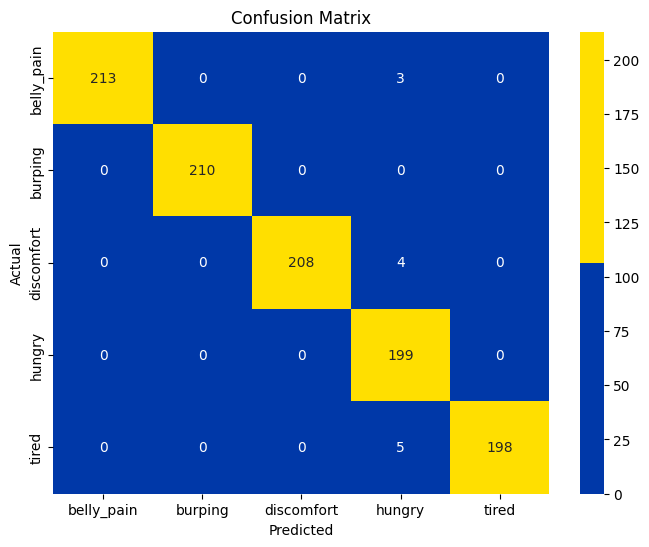

In [22]:
plt.figure(figsize=(8, 6))
yellow = (255 / 255, 223 / 255, 0 / 255)
blue = (0 / 255, 56 / 255, 168 / 255)
custom_cmap = sns.color_palette([blue, yellow])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=custom_cmap, xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# import pickle

# with open("Forest_5_98.pkl","wb") as file:
#     pickle.dump(forest_model, file)

In [19]:
import pickle
with open("Forest_5_98.pkl", "rb") as file:
    my_forest = pickle.load(file)

In [23]:
def predict(audio_features, model):
    features_flatten = audio_features.flatten()
    required_features = 1200
    repeat_times = required_features // len(features_flatten) + 1
    extended_features = np.tile(features_flatten, repeat_times)[:required_features]
    extended_features = np.expand_dims(extended_features, axis=0)  
    
    prediction = model.predict(extended_features)
    return prediction

In [24]:
class_labels = {
    0: "belly_pain",
    1: "burping",
    2: "discomfort",
    3: "hungry",
    4: "tired"
}

In [25]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [26]:
folder = '../Data/for_prediction_5_class/'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
for subfolder in os.listdir(folder):
    subfolder_path = os.path.join(folder, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing files in folder: {subfolder_path}")  # Добавлен вывод пути к папке
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(subfolder_path, file_name)
                
                mfcc_features = extract_mfcc(file_path)
                
                prediction_index = predict(mfcc_features, my_forest)
                
                prediction_label = class_labels.get(prediction_index[0], "Неизвестный класс")
                
                print(f"Predicted class for {file_name} is: {prediction_label}")


Processing files in folder: ../Data/for_prediction_5_class/belly_pain
Predicted class for 0-1697236185005666226.wav is: belly_pain
Predicted class for 0-1697236195017017400.wav is: belly_pain
Predicted class for 549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav is: hungry
Predicted class for ae5f103b-5fee-442f-bb1b-d9d0570c46ab-1431533857965-1.7-m-26-bp.wav is: hungry
Predicted class for Au1_gen-belly_pain-1-0-643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138536-1.wav is: belly_pain
Predicted class for Au1_gen-belly_pain-1-0-69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.wav is: belly_pain
Predicted class for Au2_gen-belly_pain-8-0-d6cda191-4962-4308-9a36-46d5648a95ed-1431159262344-1.wav is: belly_pain
Predicted class for Au2_gen-belly_pain-8-0-d6cda191-4962-4308-9a36-46d5648a95ed-1431700390946-1.wav is: belly_pain
Predicted class for gen-belly_pain-1-0-C421C6FE-DFEE-4080-8AEA-848E7CE4756B-1430548333-1.wav is: belly_pain
Processing files in folder: ../Data/for_prediction